In [76]:
pip install python-math

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import quimb as qu
import quimb.tensor as qtn
import math

# Tree-TensorNetwork

Following https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.155131

### Definition

<img src="./images/diagram_TTN.png" alt="Example Image" width="1000" style="display: block; margin-left: auto; margin-right: auto;" />

As illustrated in Fig. 1(b), each circle represents
a tensor; each edge of the circle represents an individual
index of the tensor. The first tensor is a matrix connecting the
second and third tensors, while the remaining tensors are all
three-order tensors with three indices. The index between two
tensors is called a virtual bond, which would be contracted
hereafter. The left and right indices of the tensors in the
bottom of the TTN are respectively connected to two pixels
of the input image and hence are called physical bonds.

The bond dimension in a tensor network refers to the dimension of the shared index (or bond) connecting two tensors. 
Higher bond dimensions allow more complex entanglement between subsystems to be represented. In quantum many-body systems, the bond dimension represents the number of states used to approximate the entanglement structure.

Since bond dimension represents on how many indices we are summing, it is related to how well we can represent states with our tensor network.
In the context of Matrix Product States (MPS), the bond dimension directly corresponds to the Schmidt rank of the state for each bipartition. If the bond dimension is h , the MPS can capture states with a maximum Schmidt rank of h.

$|\psi\rangle=\sum_{i=1}^D \lambda_i\left|u_i\right\rangle_A \otimes\left|v_i\right\rangle_B$, where D is the Schmidt rank, the number of non-zero $\lambda$, which quantifies the enganglement between the two subsystems A and B (for D=1 the state is separable).

In [98]:
number_physical_indexes = 8
bond_dimension = 2
number_layers = 3

TTN_shape = [int(number_physical_indexes/2),int(number_physical_indexes/4),int(number_physical_indexes/8)] 

index = [[] for i in range(number_layers)]
index[0] = [f'ph{i}' for i in range(number_physical_indexes)]
index[1] = [f'b0{i}' for i in range(TTN_shape[0])]
index[2] = [f'b1{i}' for i in range(TTN_shape[1])]

tensor = [[] for i in range(number_layers)]
tensor[0] = [qtn.rand_tensor([2, 2, 2], inds=[index[0][2*i],index[0][2*i+1],index[1][i]],tags='t0') for i in range(TTN_shape[0])]
tensor[1] = [qtn.rand_tensor([2, 2, 2], inds=[index[1][2*i],index[1][2*i+1],index[2][i]],tags='t1') for i in range(TTN_shape[1])]
tensor[2] = [qtn.rand_tensor([2, 2], inds=[index[2][2*i],index[2][2*i+1]],tags='t2') for i in range(TTN_shape[2])]

tensor_network = qtn.TensorNetwork(tensor)

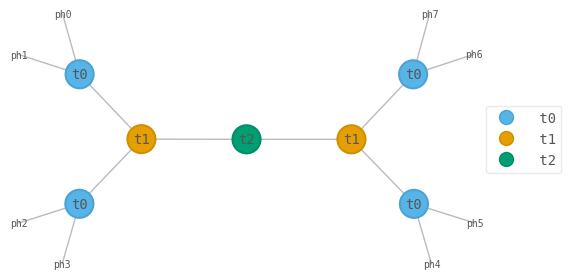

In [73]:
tensor_network.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)

We can contract the whole tensor network and calculate the forbenius norm of the resulting rank-8 tensor.

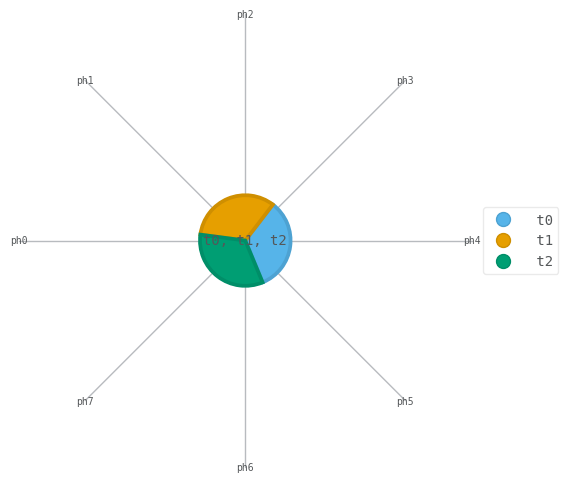

norm:  13.461138549362293


In [103]:
contracted = tensor_network.contract(all, optimize='auto-hq')
contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
print('norm: ',contracted.norm())

### Canonizing

We can now procede in canonicalization procedure for each layer of the TNN, taking the root tensor as central tensor. In this procedure we have to keep an eye on indexes, since the QR decomposition, the first block of indices is assigned to Q and the second one (in our case, the only "upper" one) is assigned to R, to be contracted with the next layer. The algorithm creates a new set of indexes beetween the first and second layer, that we have to rename.

<div style="text-align: center;">
    <img src="./images/canonize-bond.png" alt="Example Image" width="1500" style="display: block; margin-left: auto; margin-right: auto;"/>
    <p>The arrow on U means it's unitary</p>
</div>

Quimb has a default algorith to canonize bonds

In [100]:
for i in range(TTN_shape[1]):
    qtn.tensor_canonize_bond(tensor[0][2*i], tensor[1][i])
    qtn.tensor_canonize_bond(tensor[0][2*i+1], tensor[1][i])
for i in range(TTN_shape[2]):
    qtn.tensor_canonize_bond(tensor[1][2*i], tensor[2][i])
    qtn.tensor_canonize_bond(tensor[1][2*i+1], tensor[2][i])

In [104]:
print('root norm: ',tensor[2][0].norm())

root norm:  13.461138549362298


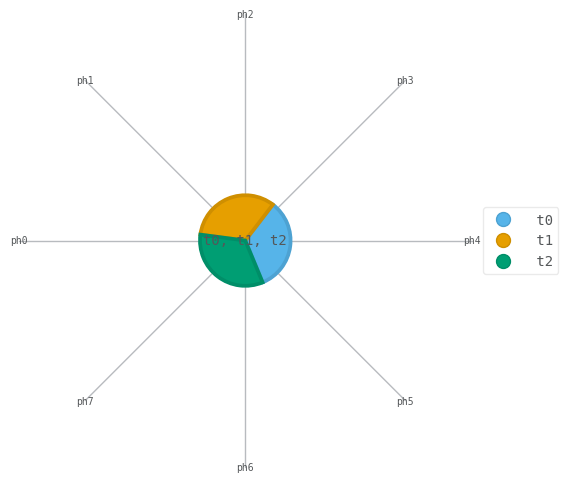

13.461138549362293


In [102]:
contracted = tensor_network.contract(all, optimize='auto-hq')
contracted.draw(color=['t0','t1','t2'],show_inds=True,show_tags=True)
print(contracted.norm())

Canonization preserves Forbenius norm and the norm of the whole tensor network is given by the norm of the root.